In [1]:
import random
import traceback
import math
from heapq import heappop, heappush
from pathlib import Path
from textwrap import dedent
from typing import Callable, Dict, Iterable, List, Optional, Tuple, Type, Union

import matplotlib.pyplot as plt
import numpy as np
import numpy.typing as npt
from PIL import Image, ImageDraw

%matplotlib inline

In [2]:
maps_for_tests = ["AR0301SR.map", "den101d.map", "London_1_256.map"]

## Grid Map Representation

In [3]:
class Map:
    """
    Represents a square grid environment for our moving agent.

    Attributes
    ----------
    _width : int
        The number of columns in the grid.

    _height : int
        The number of rows in the grid.

    _cells : np.ndarray
        A binary matrix representing the grid where 0 represents a traversable cell, and 1 represents a blocked cell.
    """

    def __init__(self, cells: npt.NDArray):
        """
        Initializes the map using a 2D array of cells.

        Parameters
        ----------
        cells : np.ndarray
            A binary matrix representing the grid. 0 indicates a traversable cell, and 1 indicates a blocked cell.
        """
        self._width = cells.shape[1]
        self._height = cells.shape[0]
        self._cells = cells

    def in_bounds(self, i: int, j: int) -> bool:
        """
        Checks if the cell (i, j) is within the grid boundaries.

        Parameters
        ----------
        i : int
            Row number of the cell in the grid.
        j : int
            Column number of the cell in the grid.

        Returns
        ----------
        bool
            True if the cell is inside the grid, False otherwise.
        """
        return 0 <= j < self._width and 0 <= i < self._height

    def traversable(self, i: int, j: int) -> bool:
        """
        Checks if the cell (i, j) is not an obstacle.

        Parameters
        ----------
        i : int
            Row number of the cell in the grid.
        j : int
            Column number of the cell in the grid.

        Returns
        ----------
        bool
            True if the cell is traversable, False if it's blocked.
        """
        return not self._cells[i, j]

    def get_neighbors(self, i: int, j: int) -> List[Tuple[int, int]]:
        """
        Gets a list of neighboring cells as (i, j) tuples.
        Assumes that the grid is 4-connected, allowing moves only in cardinal directions.

        Parameters
        ----------
        i : int
            Row number of the cell in the grid.
        j : int
            Column number of the cell in the grid.

        Returns
        ----------
        neighbors : List[Tuple[int, int]]
            List of neighboring cells.
        """
        neighbors = []
        delta = ((0, 1), (1, 0), (0, -1), (-1, 0), (1, 1), (1, -1), (-1, 1), (-1, -1))
        for dx, dy in delta:
            ni, nj = i + dx, j + dy
            if self.in_bounds(ni, nj) and self.traversable(ni, nj):
                neighbors.append((ni, nj))
        return neighbors

    def get_size(self) -> Tuple[int, int]:
        """
        Returns the size of the grid in cells.

        Returns
        ----------
        (height, width) : Tuple[int, int]
            Number of rows and columns in the grid.
        """
        return self._height, self._width

In [4]:
def convert_string_to_cells(cell_str: str) -> npt.NDArray:
    """
    Converts a string representation of a grid map, with '#' for obstacles and '.' for free cells, into a binary matrix.

    Parameters
    ----------
    cell_str : str
        String containing grid map information ('#' for obstacles and '.' for free cells).

    Returns
    ----------
    cells : np.ndarray
        Binary matrix representing the grid map.
    """
    lines = cell_str.replace(" ", "").split("\n")

    cells = np.array(
        [[0 if char == "." else 1 for char in line] for line in lines if line],
        dtype=np.int8,
    )
    return cells

In [5]:
def compute_cost(i1: int, j1: int, i2: int, j2: int) -> Union[int, float]:
    """
    Computes the cost of simple moves between cells (i1, j1) and (i2, j2).

    Parameters
    ----------
    i1 : int
        Row number of the first cell in the grid.
    j1 : int
        Column number of the first cell in the grid.
    i2 : int
        Row number of the second cell in the grid.
    j2 : int
        Column number of the second cell in the grid.

    Returns
    ----------
    int | float
        Cost of the move between cells.

    Raises
    ----------
    ValueError
        If trying to compute the cost of a non-supported move (only cardinal moves are supported).
    """
    d = abs(i1 - i2) + abs(j1 - j2)
    if d == 1:  # Cardinal move
        return 1
    elif d == 2:  # Diagonal move
        return math.sqrt(2)
    else:
        raise ValueError("Trying to compute the cost of a non-supported move!")

## Search Node


In [6]:
class Node:
    """
    Represents a search node.

    Attributes
    ----------
    i : int
        Row coordinate of the corresponding grid element.
    j : int
        Column coordinate of the corresponding grid element.
    g : float | int
        g-value of the node.
    h : float | int
        h-value of the node
    f : float | int
        f-value of the node
    parent : Node
        Pointer to the parent node.
    """

    def __init__(
        self,
        i: int,
        j: int,
        g: Union[float, int] = 0,
        h: Union[float, int] = 0,
        f: Optional[Union[float, int]] = None,
        parent: "Node" = None,
    ):
        """
        Initializes a search node.

        Parameters
        ----------
        i : int
            Row coordinate of the corresponding grid element.
        j : int
            Column coordinate of the corresponding grid element.
        g : float | int
            g-value of the node.
        h : float | int
            h-value of the node (always 0 for Dijkstra).
        f : float | int
            f-value of the node (always equal to g-value for Dijkstra).
        parent : Node
            Pointer to the parent node.
        """
        self.i = i
        self.j = j
        self.g = g
        self.h = h
        if f is None:
            self.f = self.g + h
        else:
            self.f = f
        self.parent = parent

    def __eq__(self, other):
        """
        Checks if two search nodes are the same, which is needed to detect duplicates in the search tree.
        """
        if not isinstance(other, Node):
            return NotImplemented
        return (self.i, self.j) == (other.i, other.j)

    def __hash__(self):
        """
        Makes the Node object hashable, allowing it to be used in sets/dictionaries.
        """
        return hash((self.i, self.j))

    def __lt__(self, other):
        """
        Compares the keys (i.e., the f-values) of two nodes, needed for sorting/extracting the best element from OPEN.
        """
        return self.f < other.f

## Visualization

In [7]:
def draw_rectangle(draw, node, scale, color):
    """Draws a rectangle on the grid, given the node and the desired color."""
    draw.rectangle(
        (
            node.j * scale,
            node.i * scale,
            (node.j + 1) * scale - 1,
            (node.i + 1) * scale - 1,
        ),
        fill=color,
        width=0,
    )


def draw(
    grid_map: Map,
    start: Optional[Node] = None,
    goal: Optional[Node] = None,
    path: Optional[Iterable[Node]] = None,
    nodes_discovered: Optional[Iterable[Node]] = None,
    nodes_expanded: Optional[Iterable[Node]] = None,
    nodes_reexpanded: Optional[Iterable[Node]] = None,
):
    """
    Visualizes the environment, path, and expanded/not yet expanded/re-expanded nodes.

    Re-expansions don't occur in Dijkstra's algorithm, but are included for potential future use.

    Parameters
    ----------
    grid_map : Map
        Environment represented as a grid.
    start, goal : Optional[Node], Optional[Node]
        Nodes for the start and goal positions of the agent.
    path : Optional[Iterable[Node]]
        Sequence of nodes representing the path between start and goal.
    nodes_discovered : Optional[Iterable[Node]]
        Nodes that were discovered during the search process.
    nodes_expanded : Optional[Iterable[Node]]
        Nodes that were expanded during the search process.
    nodes_reexpanded : Optional[Iterable[Node]]
        Nodes that were re-expanded during the search process.
    """
    scale = 5
    height, width = grid_map.get_size()
    im = Image.new("RGB", (width * scale, height * scale), color="white")
    draw = ImageDraw.Draw(im)

    # Draw blocked cells
    for i in range(height):
        for j in range(width):
            if not grid_map.traversable(i, j):
                draw.rectangle(
                    (j * scale, i * scale, (j + 1) * scale - 1, (i + 1) * scale - 1),
                    fill=(70, 80, 80),
                )

    node_colors = [
        (nodes_discovered, (213, 219, 219)),
        (nodes_expanded, (131, 145, 146)),
        (nodes_reexpanded, (255, 145, 146)),
    ]

    for nodes, color in node_colors:
        if nodes is not None:
            for node in nodes:
                draw_rectangle(draw, node, scale, color)

    if path is not None:
        for step in path:
            color = (52, 152, 219) if grid_map.traversable(step.i, step.j) else (230, 126, 34)
            draw_rectangle(draw, step, scale, color)

    if start is not None and grid_map.traversable(start.i, start.j):
        draw_rectangle(draw, start, scale, (40, 180, 99))

    if goal is not None and grid_map.traversable(goal.i, goal.j):
        draw_rectangle(draw, goal, scale, (231, 76, 60))

    _, ax = plt.subplots(dpi=150)
    ax.axes.xaxis.set_visible(False)
    ax.axes.yaxis.set_visible(False)
    plt.imshow(np.asarray(im))
    plt.show()

## Implementing the Search Tree (i.e., OPEN and CLOSED)

In [8]:
class SearchTreePQD:
    """
    SearchTree using a priority queue for OPEN and a dictionary for CLOSED.
    """

    def __init__(self):
        self._open = []  # Priority queue for nodes in OPEN
        self._closed = {}  # Dictionary for nodes in CLOSED (expanded nodes)
        self._enc_open_dublicates = 0  # Number of dublicates encountered in OPEN

    def __len__(self) -> int:
        """
        Returns the size of the search tree. Useful for assessing the memory
        footprint of the algorithm, especially at the final iteration.
        """
        return len(self._open) + len(self._closed)

    def open_is_empty(self) -> bool:
        """
        Checks if OPEN is empty.
        If true, the main search loop should be interrupted.
        """
        return len(self._open) == 0

    def add_to_open(self, item: Node):
        """
        Adds a node to the search tree, specifically to OPEN. This node is either
        entirely new or a duplicate of an existing node in OPEN.
        This implementation detects duplicates lazily; thus, nodes are added to
        OPEN without initial duplicate checks.
        """
        self._open.append(item)

    def get_best_node_from_open(self) -> Optional[Node]:
        """
        Retrieves the best node from OPEN, defined by the minimum key.
        This node will then be expanded in the main search loop.

        Duplicates are managed here. If a node has been expanded previously
        (and is in CLOSED), it's skipped and the next best node is considered.

        Returns None if OPEN is empty.
        """
        while self._open:
            best_node = min(self._open, key=lambda x: x.f)
            self._open.remove(best_node)
            if not self.was_expanded(best_node):
                return best_node
            self._enc_open_dublicates += 1
        return None

    def add_to_closed(self, item: Node):
        """
        Adds a node to the CLOSED dictionary.
        """
        self._closed[(item.i, item.j)] = item

    def was_expanded(self, item: Node) -> bool:
        """
        Checks if a node has been previously expanded.
        """
        return (item.i, item.j) in self._closed

    @property
    def opened(self):
        return self._open

    @property
    def expanded(self):
        return self._closed.values()

    @property
    def number_of_open_dublicates(self):
        return self._enc_open_dublicates

## Validating the Results

In [9]:
def make_path(goal: Node) -> Tuple[List[Node], Union[float, int]]:
    """
    Creates a path by tracing parent pointers from the goal node to the start node.
    It also returns the path's length.

    Parameters
    ----------
    goal : Node
        Pointer to the goal node in the search tree.

    Returns
    -------
    Tuple[List[Node], float]
        Path and its length.
    """
    length = goal.g
    current = goal
    path = []
    while current.parent:
        path.append(current)
        current = current.parent
    path.append(current)
    return path[::-1], length

In [10]:
def read_task_from_file(
    path: str,
) -> Tuple[npt.NDArray, int, int, int, int, float]:
    """
    Reads map, start/goal positions, and true value of path length between the given start and goal from a file.

    Parameters
    ----------
    path : str
        Path to a file with the pathfinding problem instance.

    Returns
    -------
    cells : npt.NDArray
        Matrix of grid map cells.
    start_i, start_j : int, int
        Position of the start cell in the grid.
    goal_i, goal_j : int, int
        Position of the goal cell in the grid.
    length : float
        True value of the path's length between the given start and goal.
    """

    tasks = []
    with open(path) as tasks_file:
        height = int(next(tasks_file))
        width = int(next(tasks_file))

        # Read the map section
        map_lines = [next(tasks_file) for _ in range(height)]
        map_str = "".join(map_lines)
        cells = convert_string_to_cells(map_str)

        while True:
            line =  tasks_file.readline()
            if not line:
                break
            
            tasks.append(tuple(float(i) if '.' in i else int(i) for i in line.split(',')))
        # start_i = int(next(tasks_file))
        # start_j = int(next(tasks_file))
        # goal_i = int(next(tasks_file))
        # goal_j = int(next(tasks_file))
        # length = float(next(tasks_file))

    return cells, tasks

In [11]:
def massive_test(search_function, data_path, *args) -> Dict:
    """
    The `massive_test` function runs the `search_function` on a set of different tasks
    (for example, from the directory `data/`) using *args as optional arguments.
    For every task, it displays a short report:
     - 'Path found!' along with some statistics if a path was found.
     - 'Path not found!' if a path wasn't found.
     - 'Execution error' if an error occurred during the execution of the search_function.

    The function returns a dictionary containing statistics with the following keys:
     - "corr" — correctness of each path length (True/False).
     - "len" — the length of each path (0.0 if a path wasn't found).
     - "st_size" — the size of the resultant search tree for each task.
     - "steps" — the number of algorithm steps for each task.

    Parameters
    ----------
    search_function : Callable
        The implemented search method.
    data_path : str
        Path to the directory containing tasks.

    Returns
    -------
    stat : Dict
        A dictionary containing statistics.

    """
    stat = {
        "corr": [],
        "len": [],
        "st_size": [],
        "steps": [],
        "len_diff": [],
        "found": [],
    }

    # if num_of_tasks is None or num_of_tasks <= 0:
    #     print("Incorrect number of tasks. Testing halted!")
    #     return stat
    
    task_file_name = data_path
    # task_file_name = Path(data_path) / f"{task_count}.map"
    cells, tasks = read_task_from_file(task_file_name)
    task_map = Map(cells)
    counter = 1
    for start_j, start_i, goal_j, goal_i, length in tasks:
        try:
            (
                found,
                end_node,
                number_of_steps,
                search_tree_size,
                *other_results,
            ) = search_function(task_map, start_i, start_j, goal_i, goal_j, *args)

            stat["found"].append(found)
            if found:
                _, path_length = make_path(end_node)
                correct = round(path_length) == round(length)

                # print(
                    # f"Task: #{counter}. Path found! Length: {path_length}, true length: {length}. Search tree size: {search_tree_size}. "
                    # f"Number of steps: {number_of_steps}. Correct: {correct}"
                # )

                stat["len"].append(path_length)
                stat["corr"].append(correct)
                if not correct:
                    stat["len_diff"].append(abs(length - path_length))
            else:
                # print(f"Task: #{counter}. Path not found!")
                stat["len"].append(0.0)
                stat["corr"].append(False)

            stat["st_size"].append(search_tree_size)
            stat["steps"].append(number_of_steps)
            counter += 1

        except Exception as e:
            print(f"Execution error: {e}")
            traceback.print_exc()

    return stat

In [12]:
def simple_test(data_path, search_function: Callable, task: Union[int, None], *args):
    """
    Function `simple_test` runs `search_function` on one task. Use a number from 0 to 24 to choose a specific debug task
    on a simple map, or use None to select a random task from this pool. The function displays:
     - 'Path found!' and some statistics if a path was found.
     - 'Path not found!' if a path was not discovered.
     - 'Execution error' if an error occurred during the execution of the search_function.
    In the first case, the function also provides a visualization of the task.

    Parameters
    ----------
    search_function : Callable
        Implementation of the search method.
    task : int | None
        A number from 0 to 24 to choose a specific debug task on a simple map,
        or None to select a random task from this pool.
    *args
        Additional arguments passed to the search function.
    """

    task_file_name = data_path
    # task_file_name = Path(data_path) / f"{task_count}.map"
    cells, tasks = read_task_from_file(task_file_name)
    task_map = Map(cells)

    if (task is None) or not (0 <= task < 100):
        task = random.randint(0, 24)


    print(tasks[task])
    
    start = Node(tasks[task][1], tasks[task][0])
    goal = Node(tasks[task][3], tasks[task][2])
    length = tasks[task][4]

    

    try:
        (
            found,
            end_node,
            number_of_steps,
            search_tree_size,
            *other_results,
        ) = search_function(task_map, start.i, start.j, goal.i, goal.j, *args)

        if found:
            path, path_length = make_path(end_node)
            correct = int(path_length) == int(length)
            draw(task_map, start, goal, path, *other_results)
            print(
                f"Path found! Length: {path_length}. Search tree size: {search_tree_size}. Number of steps: {number_of_steps}. Correct: {correct}"
            )
        else:
            print("Path not found!")
        return

    except Exception as e:
        print(f"Execution error: {e}")
        traceback.print_exc()

## Эвристика

In [13]:
def octile(x1, y1, x2, y2):
    di = abs(x1 - x2)
    dj = abs(y1 - y2)
    return max(di, dj) * 1.4142135623730951 + abs(di - dj) * 1.0


## A* Algorithm Without Reexpansions

In [14]:
def astar(
    task_map: Map,
    start_i: int,
    start_j: int,
    goal_i: int,
    goal_j: int,
    heuristic_func: Callable,
    search_tree: Type[SearchTreePQD],
) -> Tuple[bool, Optional[Node], int, int, Optional[Iterable[Node]], Optional[Iterable[Node]]]:
    """
    Implements the A* search algorithm.

    Parameters
    ----------
    task_map : Map
        The grid or map being searched.
    start_i, start_j : int, int
        Starting coordinates.
    goal_i, goal_j : int, int
        Goal coordinates.
    heuristic_func : Callable
        Heuristic function for estimating the distance from a node to the goal.
    search_tree : Type[SearchTreePQD]
        The search tree to use.

    Returns
    -------
    Tuple[bool, Optional[Node], int, int, Optional[Iterable[Node]], Optional[Iterable[Node]]]
        Tuple containing:
        - A boolean indicating if a path was found.
        - The last node in the found path or None.
        - Number of algorithm iterations.
        - Size of the resultant search tree.
        - OPEN set nodes for visualization or None.
        - CLOSED set nodes.
    """
    ast = search_tree()
    steps = 0

    start_node = Node(start_i, start_j, h=heuristic_func(start_i, start_j, goal_i, goal_j))
    ast.add_to_open(start_node)

    while not ast.open_is_empty():
        steps += 1
        current_node = ast.get_best_node_from_open()

        if current_node is None:
            return False, None, steps, len(ast), None, ast.expanded

        if (current_node.i, current_node.j) == (goal_i, goal_j):
            return True, current_node, steps, len(ast), ast.opened, ast.expanded

        ast.add_to_closed(current_node)

        for neighbor in task_map.get_neighbors(current_node.i, current_node.j):
            neighbor_node = Node(
                neighbor[0],
                neighbor[1],
                g=current_node.g + compute_cost(current_node.i, current_node.j, neighbor[0], neighbor[1]),
                h=heuristic_func(neighbor[0], neighbor[1], goal_i, goal_j),
                parent=current_node
            )

            if not ast.was_expanded(neighbor_node):
                ast.add_to_open(neighbor_node)

    return False, None, steps, len(ast), None, ast.expanded

In [15]:
def w_astar(
    task_map: Map,
    start_i: int,
    start_j: int,
    goal_i: int,
    goal_j: int,
    heuristic_func: Callable,
    search_tree: Type[SearchTreePQD],
    w: float
) -> Tuple[bool, Optional[Node], int, int, Optional[Iterable[Node]], Optional[Iterable[Node]]]:
    ast = search_tree()
    steps = 0

    start_node = Node(start_i, start_j, h=heuristic_func(start_i, start_j, goal_i, goal_j))
    ast.add_to_open(start_node)

    while not ast.open_is_empty():
        steps += 1
        current_node = ast.get_best_node_from_open()

        if current_node is None:
            return False, None, steps, len(ast), None, ast.expanded

        if (current_node.i, current_node.j) == (goal_i, goal_j):
            return True, current_node, steps, len(ast), ast.opened, ast.expanded

        ast.add_to_closed(current_node)

        for neighbor in task_map.get_neighbors(current_node.i, current_node.j):
            n_g = current_node.g + compute_cost(current_node.i, current_node.j, neighbor[0], neighbor[1])
            n_h = heuristic_func(neighbor[0], neighbor[1], goal_i, goal_j)
            neighbor_node = Node(
                neighbor[0],
                neighbor[1],
                g=n_g,
                h=heuristic_func(neighbor[0], neighbor[1], goal_i, goal_j),
                f=n_g + w * n_h,
                parent=current_node
            )

            if not ast.was_expanded(neighbor_node):
                ast.add_to_open(neighbor_node)

    return False, None, steps, len(ast), None, ast.expanded

In [18]:
def plot_results(data, title):
    plt.figure()
    
    plt.bar(['Правильные', 'Неправильные'], [data['corr'].count(True), data['corr'].count(False)], color=['green', 'red'])
    plt.title(title)

## Baldurs Gate II (published September, 2000)

карта AR0301SR.map. Первые 100 заданий

### Про карту

Карта состоит из различных комнат в одним/двумя входами, различных коридоров.

Были выбраны 100 заданий с двумя группами сложности (можно посмотреть на графике ниже):
1) простые (идеальные длины пути до 60 единиц)
2) сложные (идеальные длины пути от 120 до 200 единиц)

При решений отслеживаются: найден ли пути, является ли путь идеальным, размер дерева поиска, длина найденного пути.

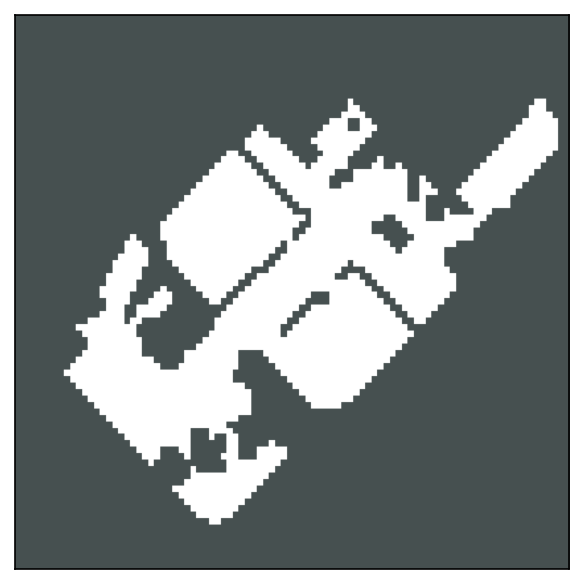

In [19]:
task_file_name = "data/" + maps_for_tests[0]
cells, tasks = read_task_from_file(task_file_name)
task_map = Map(cells)

start = Node(0,0)
goal = Node(1,1)

draw(task_map, start, goal)

### WA* с различными w

In [64]:
%time resWA1_05 = massive_test(w_astar, "data/" + maps_for_tests[0], octile, SearchTreePQD, 1.05)

CPU times: user 23.8 s, sys: 1.93 ms, total: 23.8 s
Wall time: 23.8 s


In [65]:
%time resWA1_1 = massive_test(w_astar, "data/" + maps_for_tests[0], octile, SearchTreePQD, 1.1)

CPU times: user 23.3 s, sys: 1.93 ms, total: 23.3 s
Wall time: 23.3 s


In [66]:
%time resWA1_5 = massive_test(w_astar, "data/" + maps_for_tests[0], octile, SearchTreePQD, 1.5)

CPU times: user 20.7 s, sys: 968 μs, total: 20.7 s
Wall time: 20.7 s


In [67]:
%time resWA2 = massive_test(w_astar, "data/" + maps_for_tests[0], octile, SearchTreePQD, 2)

CPU times: user 18.7 s, sys: 958 μs, total: 18.7 s
Wall time: 18.7 s


In [68]:
%time resWA3 = massive_test(w_astar, "data/" + maps_for_tests[0], octile, SearchTreePQD, 3)

CPU times: user 18.6 s, sys: 969 μs, total: 18.6 s
Wall time: 18.6 s


In [69]:
%time resWA5 = massive_test(w_astar, "data/" + maps_for_tests[0], octile, SearchTreePQD, 5)

CPU times: user 18.4 s, sys: 991 μs, total: 18.4 s
Wall time: 18.4 s


### A*

In [70]:
%time resA = massive_test(astar, "data/" + maps_for_tests[0], octile, SearchTreePQD)

CPU times: user 24 s, sys: 2 μs, total: 24 s
Wall time: 24 s


### Отношения: время выполнения A* / время выполнения WA*

In [76]:
print("WA* 1.05:", 24 / 23.8)
print("WA* 1.1:", 24 / 23.5)
print("WA* 1.5:", 24 / 20.7)
print("WA* 2:", 24 / 18.7)
print("WA* 3:", 24 / 18.6)
print("WA* 5:", 24 / 18.4)

WA* 1.05: 1.0084033613445378
WA* 1.1: 1.0212765957446808
WA* 1.5: 1.1594202898550725
WA* 2: 1.2834224598930482
WA* 3: 1.2903225806451613
WA* 5: 1.3043478260869565


In [77]:
print("Средняя разность A* / средняя разность WA*: (разность между найденной и правильной длиной пути)")
print("WA* 1.05:", (sum(resWA1_05['len_diff']) / len(resWA1_05['len_diff'])) / (sum(resA['len_diff']) / len(resA['len_diff'])))
print("WA* 1.1:", (sum(resWA1_1['len_diff']) / len(resWA1_1['len_diff'])) / (sum(resA['len_diff']) / len(resA['len_diff'])))
print("WA* 1.5:", (sum(resWA1_5['len_diff']) / len(resWA1_5['len_diff'])) / (sum(resA['len_diff']) / len(resA['len_diff'])))
print("WA* 2:", (sum(resWA2['len_diff']) / len(resWA2['len_diff'])) / (sum(resA['len_diff']) / len(resA['len_diff'])))
print("WA* 3:", (sum(resWA3['len_diff']) / len(resWA3['len_diff'])) / (sum(resA['len_diff']) / len(resA['len_diff'])))
print("WA* 5:", (sum(resWA5['len_diff']) / len(resWA5['len_diff'])) / (sum(resA['len_diff']) / len(resA['len_diff'])))

Средняя разность A* / средняя разность WA*: (разность между найденной и правильной длиной пути)
WA* 1.05: 1.0431997583558672
WA* 1.1: 1.0719078045922468
WA* 1.5: 1.4356324068192396
WA* 2: 1.526601623053689
WA* 3: 1.7480760873831922
WA* 5: 1.7810632410645277


In [78]:
print("Количество найденных решений:")
print("WA* 1.05:", str(resWA1_05['found'].count(True)) + "/100")
print("WA* 1.1:", str(resWA1_1['found'].count(True)) + "/100")
print("WA* 1.5:", str(resWA1_5['found'].count(True)) + "/100")
print("WA* 2:", str(resWA2['found'].count(True)) + "/100")
print("WA* 3:", str(resWA3['found'].count(True)) + "/100")
print("WA* 5:", str(resWA5['found'].count(True)) + "/100")
print("A*:", str(resA['found'].count(True)) + "/100")
print("Количество правильных решений:")
print("WA* 1.05:", str(resWA1_05['corr'].count(True)) + "/100")
print("WA* 1.1:", str(resWA1_1['corr'].count(True)) + "/100")
print("WA* 1.5:", str(resWA1_5['corr'].count(True)) + "/100")
print("WA* 2:", str(resWA2['corr'].count(True)) + "/100")
print("WA* 3:", str(resWA3['corr'].count(True)) + "/100")
print("WA* 5:", str(resWA5['corr'].count(True)) + "/100")
print("A*:", str(resA['corr'].count(True)) + "/100")

Количество найденных решений:
WA* 1.05: 100/100
WA* 1.1: 100/100
WA* 1.5: 100/100
WA* 2: 100/100
WA* 3: 100/100
WA* 5: 100/100
A*: 100/100
Количество правильных решений:
WA* 1.05: 0/100
WA* 1.1: 0/100
WA* 1.5: 0/100
WA* 2: 0/100
WA* 3: 0/100
WA* 5: 0/100
A*: 1/100


/tmp/ipykernel_110817/668401594.py:6: UserWarning: No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.
  ax1.legend()


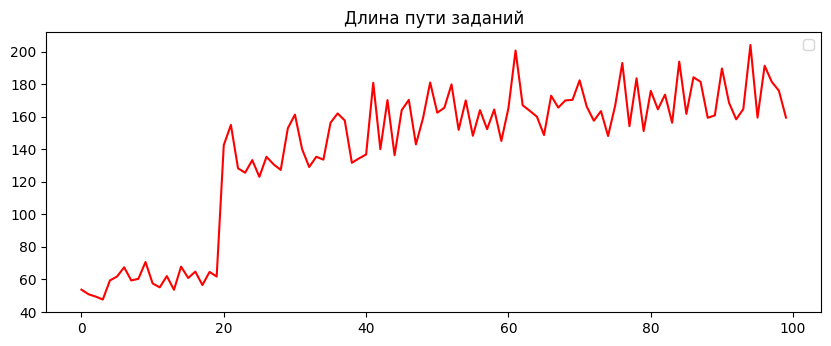

In [79]:
fig = plt.figure(num='Multiple Plots', figsize=(10, 8))

ax1 = fig.add_subplot(2, 1, 1) 
ax1.set_title("Длина пути заданий")
ax1.plot(range(len(resA['len'])), resA['len'], color='r')
ax1.legend()

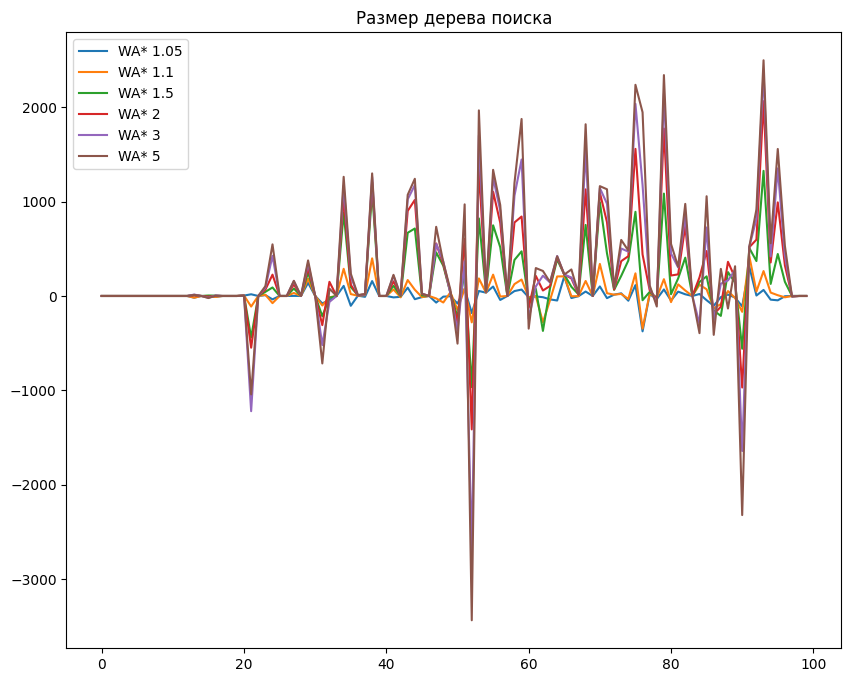

In [81]:
fig = plt.figure(num='Multiple Plots', figsize=(10, 8))

ax2 = fig.add_subplot(1, 1, 1) 
ax2.set_title('Размер дерева поиска')
ax2.plot(range(100), np.array(resA['st_size'])[:100] - np.array(resWA1_05['st_size'])[:100], label='WA* 1.05')
ax2.plot(range(100), np.array(resA['st_size'])[:100] - np.array(resWA1_1['st_size'])[:100], label='WA* 1.1')
ax2.plot(range(100), np.array(resA['st_size'])[:100] - np.array(resWA1_5['st_size'])[:100], label='WA* 1.5')
ax2.plot(range(100), np.array(resA['st_size'])[:100] - np.array(resWA2['st_size'])[:100], label='WA* 2')
ax2.plot(range(100), np.array(resA['st_size'])[:100] - np.array(resWA3['st_size'])[:100], label='WA* 3')
ax2.plot(range(100), np.array(resA['st_size'])[:100] - np.array(resWA5['st_size'])[:100], label='WA* 5')
# ax2.plot(range(len(resA['st_size'])), resA['st_size'], label='A*')
ax2.legend()
plt.show()

### Вывод по результатм на данной карте

1) При сравенинии коэффициентов насколько мы выиграли по времени и сколько потеряли по качеству (длины найденных путей), можно сделать вывод, что для каждого значения w (кроме w = 1.05) в WA* относительная потеря в качестве больше, чем выигрыш по времени.
2) Возможная причина почему у WA* на данной карте относительный выигрыш по времени меньше, чем потеря в качестве - это формат карты. Карта состоит из комнат, в большинстве своём, с одним входом, поэтому когда расстоянию напрямик придаём больший вес получается так, что алгоритм WA* часто упирается в стенку дальше от входа, чем это происходит у A*, то есть брождение по стенке сильнее увеличивает длину пути.

## Dragon Age: Origins (published November, 2009)

карта arena.map. Первые 100 заданий

### Про карту

Данная карта, как и первая, тоже представляет из себя комнаты, но в этот раз с более чётким разделением и большим количеством препятствий внутри комнат.

Были выбраны 100 заданий с двумя группами сложности (можно посмотреть на графике ниже). С длинами идельных путей от 0 до 80, то есть все задания являются относительно простыми.

При решений отслеживаются: найден ли пути, является ли путь идеальным, размер дерева поиска, длина найденного пути.

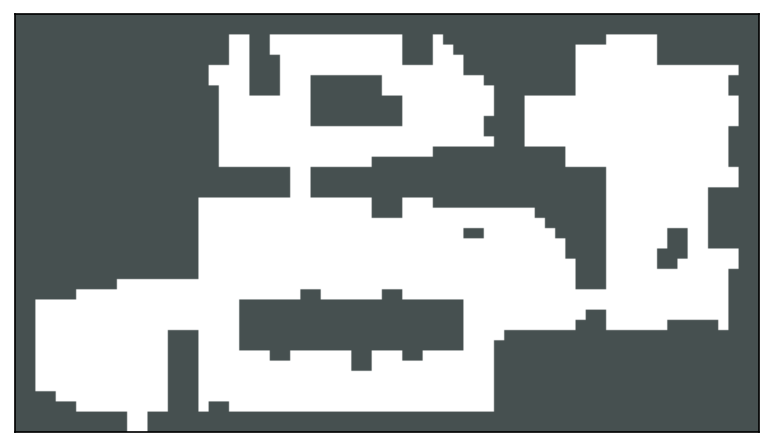

In [113]:
task_file_name = "data/" + maps_for_tests[1]
cells, tasks = read_task_from_file(task_file_name)
task_map = Map(cells)

start = Node(0,0)
goal = Node(1,1)

draw(task_map, start, goal)

### WA* с различными w

In [114]:
%time resWA1_05 = massive_test(w_astar, "data/" + maps_for_tests[1], octile, SearchTreePQD, 1.05)

CPU times: user 1.51 s, sys: 10 μs, total: 1.51 s
Wall time: 1.51 s


In [115]:
%time resWA1_1 = massive_test(w_astar, "data/" + maps_for_tests[1], octile, SearchTreePQD, 1.1)

CPU times: user 1.51 s, sys: 986 μs, total: 1.51 s
Wall time: 1.51 s


In [116]:
%time resWA1_5 = massive_test(w_astar, "data/" + maps_for_tests[1], octile, SearchTreePQD, 1.5)

CPU times: user 1.28 s, sys: 979 μs, total: 1.28 s
Wall time: 1.28 s


In [117]:
%time resWA2 = massive_test(w_astar, "data/" + maps_for_tests[1], octile, SearchTreePQD, 2)

CPU times: user 1.15 s, sys: 1 μs, total: 1.15 s
Wall time: 1.16 s


In [118]:
%time resWA3 = massive_test(w_astar, "data/" + maps_for_tests[1], octile, SearchTreePQD, 3)

CPU times: user 999 ms, sys: 2 μs, total: 999 ms
Wall time: 999 ms


In [119]:
%time resWA5 = massive_test(w_astar, "data/" + maps_for_tests[1], octile, SearchTreePQD, 5)

CPU times: user 939 ms, sys: 972 μs, total: 940 ms
Wall time: 940 ms


### A*

In [120]:
%time resA = massive_test(astar, "data/" + maps_for_tests[1], octile, SearchTreePQD)

CPU times: user 1.54 s, sys: 0 ns, total: 1.54 s
Wall time: 1.54 s


### Отношения: время выполнения A* / время выполнения WA*

In [126]:
print("WA* 1.05:", 1.54 / 1.51)
print("WA* 1.1:", 1.54 / 1.51)
print("WA* 1.5:", 1.54 / 1.28)
print("WA* 2:", 1.54 / 1.16)
print("WA* 3:", 1.54 / 0.999)
print("WA* 5:", 1.54 / 0.94)

WA* 1.05: 1.0198675496688743
WA* 1.1: 1.0198675496688743
WA* 1.5: 1.203125
WA* 2: 1.3275862068965518
WA* 3: 1.5415415415415417
WA* 5: 1.6382978723404256


In [127]:
print("Средняя разность A* / средняя разность WA*: (разность между найденной и правильной длиной пути)")
print("WA* 1.05:", (sum(resWA1_05['len_diff']) / len(resWA1_05['len_diff'])) / (sum(resA['len_diff']) / len(resA['len_diff'])))
print("WA* 1.1:", (sum(resWA1_1['len_diff']) / len(resWA1_1['len_diff'])) / (sum(resA['len_diff']) / len(resA['len_diff'])))
print("WA* 1.5:", (sum(resWA1_5['len_diff']) / len(resWA1_5['len_diff'])) / (sum(resA['len_diff']) / len(resA['len_diff'])))
print("WA* 2:", (sum(resWA2['len_diff']) / len(resWA2['len_diff'])) / (sum(resA['len_diff']) / len(resA['len_diff'])))
print("WA* 3:", (sum(resWA3['len_diff']) / len(resWA3['len_diff'])) / (sum(resA['len_diff']) / len(resA['len_diff'])))
print("WA* 5:", (sum(resWA5['len_diff']) / len(resWA5['len_diff'])) / (sum(resA['len_diff']) / len(resA['len_diff'])))

Средняя разность A* / средняя разность WA*: (разность между найденной и правильной длиной пути)
WA* 1.05: 1.0
WA* 1.1: 1.0736064816945985
WA* 1.5: 1.4267977388845279
WA* 2: 1.491475504577137
WA* 3: 1.7377646431833897
WA* 5: 1.830511843676113


In [128]:
print("Количество найденных решений:")
print("WA* 1.05:", str(resWA1_05['found'].count(True)) + "/100")
print("WA* 1.1:", str(resWA1_1['found'].count(True)) + "/100")
print("WA* 1.5:", str(resWA1_5['found'].count(True)) + "/100")
print("WA* 2:", str(resWA2['found'].count(True)) + "/100")
print("WA* 3:", str(resWA3['found'].count(True)) + "/100")
print("WA* 5:", str(resWA5['found'].count(True)) + "/100")
print("A*:", str(resA['found'].count(True)) + "/100")
print("Количество правильных решений:")
print("WA* 1.05:", str(resWA1_05['corr'].count(True)) + "/100")
print("WA* 1.1:", str(resWA1_1['corr'].count(True)) + "/100")
print("WA* 1.5:", str(resWA1_5['corr'].count(True)) + "/100")
print("WA* 2:", str(resWA2['corr'].count(True)) + "/100")
print("WA* 3:", str(resWA3['corr'].count(True)) + "/100")
print("WA* 5:", str(resWA5['corr'].count(True)) + "/100")
print("A*:", str(resA['corr'].count(True)) + "/100")

Количество найденных решений:
WA* 1.05: 97/100
WA* 1.1: 97/100
WA* 1.5: 97/100
WA* 2: 97/100
WA* 3: 97/100
WA* 5: 97/100
A*: 97/100
Количество правильных решений:
WA* 1.05: 3/100
WA* 1.1: 1/100
WA* 1.5: 3/100
WA* 2: 1/100
WA* 3: 1/100
WA* 5: 1/100
A*: 3/100


/tmp/ipykernel_110817/668401594.py:6: UserWarning: No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.
  ax1.legend()


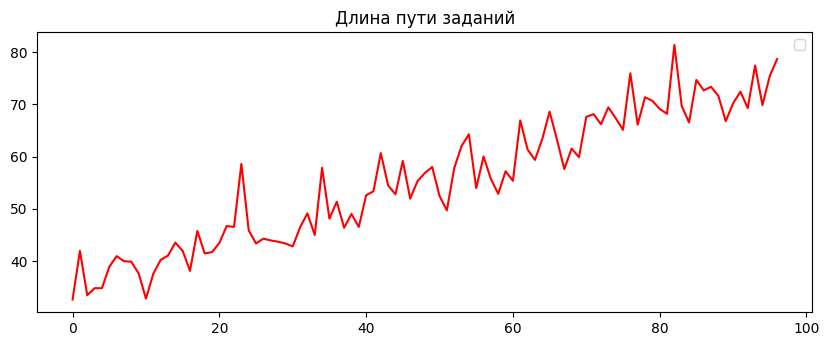

In [129]:
fig = plt.figure(num='Multiple Plots', figsize=(10, 8))

ax1 = fig.add_subplot(2, 1, 1) 
ax1.set_title("Длина пути заданий")
ax1.plot(range(len(resA['len'])), resA['len'], color='r')
ax1.legend()

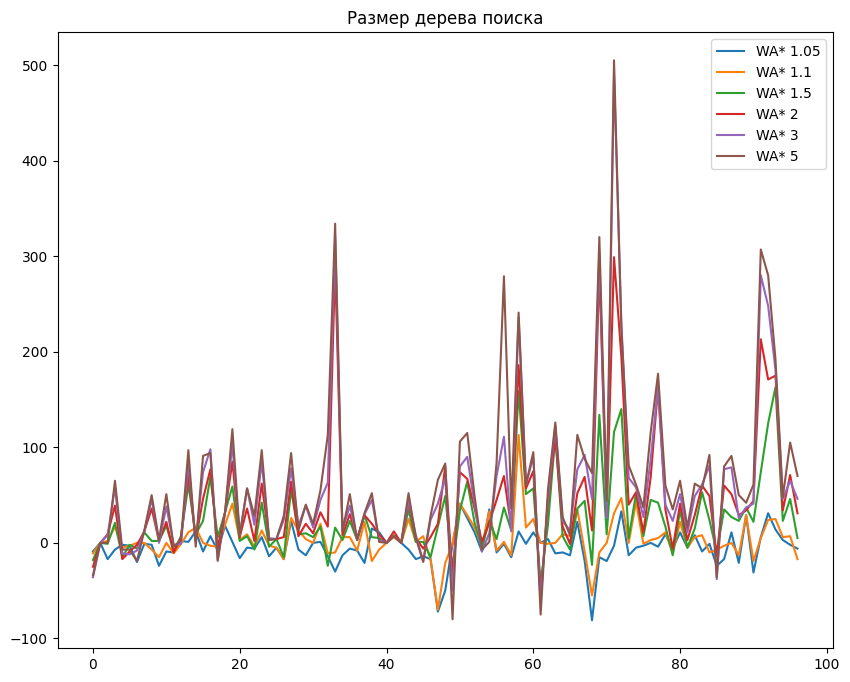

In [130]:
fig = plt.figure(num='Multiple Plots', figsize=(10, 8))

ax2 = fig.add_subplot(1, 1, 1) 
ax2.set_title('Размер дерева поиска')
ax2.plot(range(len(resWA1_05['st_size'])), np.array(resA['st_size']) - np.array(resWA1_05['st_size']), label='WA* 1.05')
ax2.plot(range(len(resWA1_1['st_size'])), np.array(resA['st_size']) - np.array(resWA1_1['st_size']), label='WA* 1.1')
ax2.plot(range(len(resWA1_5['st_size'])), np.array(resA['st_size']) - np.array(resWA1_5['st_size']), label='WA* 1.5')
ax2.plot(range(len(resWA2['st_size'])), np.array(resA['st_size']) - np.array(resWA2['st_size']), label='WA* 2')
ax2.plot(range(len(resWA3['st_size'])), np.array(resA['st_size']) - np.array(resWA3['st_size']), label='WA* 3')
ax2.plot(range(len(resWA5['st_size'])), np.array(resA['st_size']) - np.array(resWA5['st_size']), label='WA* 5')
# ax2.plot(range(len(resA['st_size'])), resA['st_size'], label='A*')
ax2.legend()

plt.show()

### Вывод по результатм на данной карте

Выводы можно сделать такие же как и для прошлой карты. Что можно дополнить, так это то, что даже на более простых заданиях в среднем выигрыш по скорости не перебивает потерю по качеству. Проблема всё таже, блуждание по стенке увеличивает длину пути. А полученный выигрыш по скорости в простых заданиях не компенсирует эти потери

## City/street maps

карта London_1_256.map. Первые 100 заданий

### Про карту

Данная карта представляет из себя город. Здесь, в отличие от прошлых двух карт, существует множество способов добраться из точки в другую, если между ними препятствие.

Были выбраны 100 заданий с двумя группами сложности (можно посмотреть на графике ниже):
1) 60 простых заданий (с длинами идеальных путей до 50 единиц)
2) 40 сложных заданий (с длинами идеальных путей от 150 до 250 единиц)

При решений отслеживаются: найден ли пути, является ли путь идеальным, размер дерева поиска, длина найденного пути.

The history saving thread hit an unexpected error (OperationalError('attempt to write a readonly database')).History will not be written to the database.


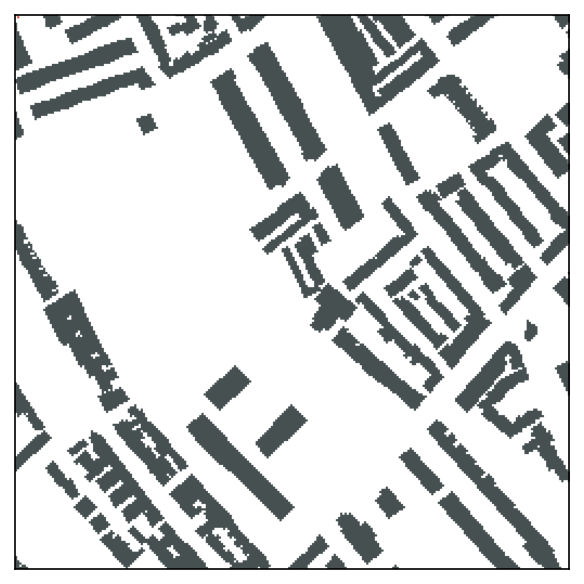

In [95]:
task_file_name = "data/" + maps_for_tests[2]
cells, tasks = read_task_from_file(task_file_name)
task_map = Map(cells)

start = Node(0,0)
goal = Node(1,1)

draw(task_map, start, goal)

### WA* с различными w

In [132]:
%time resWA1_05 = massive_test(w_astar, "data/" + maps_for_tests[2], octile, SearchTreePQD, 1.05)

CPU times: user 15.9 s, sys: 1.91 ms, total: 15.9 s
Wall time: 15.9 s


In [133]:
%time resWA1_1 = massive_test(w_astar, "data/" + maps_for_tests[2], octile, SearchTreePQD, 1.1)

CPU times: user 14.5 s, sys: 0 ns, total: 14.5 s
Wall time: 14.5 s


In [134]:
%time resWA1_5 = massive_test(w_astar, "data/" + maps_for_tests[2], octile, SearchTreePQD, 1.5)

CPU times: user 10.3 s, sys: 0 ns, total: 10.3 s
Wall time: 10.3 s


In [135]:
%time resWA2 = massive_test(w_astar, "data/" + maps_for_tests[2], octile, SearchTreePQD, 2)

CPU times: user 8.18 s, sys: 1.86 ms, total: 8.19 s
Wall time: 8.19 s


In [136]:
%time resWA3 = massive_test(w_astar, "data/" + maps_for_tests[2], octile, SearchTreePQD, 3)

CPU times: user 6.78 s, sys: 0 ns, total: 6.78 s
Wall time: 6.78 s


In [137]:
%time resWA5 = massive_test(w_astar, "data/" + maps_for_tests[2], octile, SearchTreePQD, 5)

CPU times: user 5.97 s, sys: 0 ns, total: 5.97 s
Wall time: 5.97 s


### A*

In [138]:
%time resA = massive_test(astar, "data/" + maps_for_tests[2], octile, SearchTreePQD)

CPU times: user 16.6 s, sys: 0 ns, total: 16.6 s
Wall time: 16.6 s


### Отношения: время выполнения A* / время выполнения WA*

In [144]:
print("WA* 1.05:", 16.6 / 15.9)
print("WA* 1.1:", 16.6 / 14.5)
print("WA* 1.5:", 16.6 / 10.3)
print("WA* 2:", 16.6 / 8.19)
print("WA* 3:", 16.6 / 6.78)
print("WA* 5:", 16.6 / 5.97)

WA* 1.05: 1.0440251572327044
WA* 1.1: 1.1448275862068966
WA* 1.5: 1.6116504854368932
WA* 2: 2.026862026862027
WA* 3: 2.448377581120944
WA* 5: 2.780569514237856


In [145]:
print("Средняя разность A* / средняя разность WA*: (разность между найденной и правильной длиной пути)")
print("WA* 1.05:", (sum(resWA1_05['len_diff']) / len(resWA1_05['len_diff'])) / (sum(resA['len_diff']) / len(resA['len_diff'])))
print("WA* 1.1:", (sum(resWA1_1['len_diff']) / len(resWA1_1['len_diff'])) / (sum(resA['len_diff']) / len(resA['len_diff'])))
print("WA* 1.5:", (sum(resWA1_5['len_diff']) / len(resWA1_5['len_diff'])) / (sum(resA['len_diff']) / len(resA['len_diff'])))
print("WA* 2:", (sum(resWA2['len_diff']) / len(resWA2['len_diff'])) / (sum(resA['len_diff']) / len(resA['len_diff'])))
print("WA* 3:", (sum(resWA3['len_diff']) / len(resWA3['len_diff'])) / (sum(resA['len_diff']) / len(resA['len_diff'])))
print("WA* 5:", (sum(resWA5['len_diff']) / len(resWA5['len_diff'])) / (sum(resA['len_diff']) / len(resA['len_diff'])))

Средняя разность A* / средняя разность WA*: (разность между найденной и правильной длиной пути)
WA* 1.05: 1.0551370207860495
WA* 1.1: 1.087113721492413
WA* 1.5: 1.2617296335068542
WA* 2: 1.3183718588452353
WA* 3: 1.4309280430288973
WA* 5: 1.4583637036749182


In [146]:
print("Количество найденных решений:")
print("WA* 1.05:", str(resWA1_05['found'].count(True)) + "/100")
print("WA* 1.1:", str(resWA1_1['found'].count(True)) + "/100")
print("WA* 1.5:", str(resWA1_5['found'].count(True)) + "/100")
print("WA* 2:", str(resWA2['found'].count(True)) + "/100")
print("WA* 3:", str(resWA3['found'].count(True)) + "/100")
print("WA* 5:", str(resWA5['found'].count(True)) + "/100")
print("A*:", str(resA['found'].count(True)) + "/100")
print("Количество правильных решений:")
print("WA* 1.05:", str(resWA1_05['corr'].count(True)) + "/100")
print("WA* 1.1:", str(resWA1_1['corr'].count(True)) + "/100")
print("WA* 1.5:", str(resWA1_5['corr'].count(True)) + "/100")
print("WA* 2:", str(resWA2['corr'].count(True)) + "/100")
print("WA* 3:", str(resWA3['corr'].count(True)) + "/100")
print("WA* 5:", str(resWA5['corr'].count(True)) + "/100")
print("A*:", str(resA['corr'].count(True)) + "/100")

Количество найденных решений:
WA* 1.05: 100/100
WA* 1.1: 100/100
WA* 1.5: 100/100
WA* 2: 100/100
WA* 3: 100/100
WA* 5: 100/100
A*: 100/100
Количество правильных решений:
WA* 1.05: 15/100
WA* 1.1: 15/100
WA* 1.5: 15/100
WA* 2: 15/100
WA* 3: 15/100
WA* 5: 15/100
A*: 15/100


/tmp/ipykernel_110817/668401594.py:6: UserWarning: No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.
  ax1.legend()


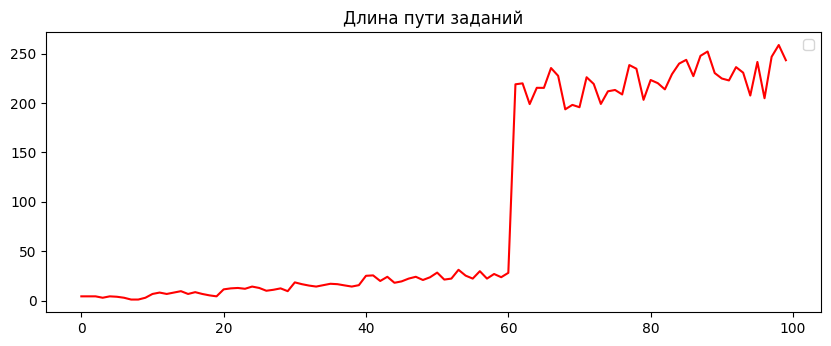

In [147]:
fig = plt.figure(num='Multiple Plots', figsize=(10, 8))

ax1 = fig.add_subplot(2, 1, 1) 
ax1.set_title("Длина пути заданий")
ax1.plot(range(len(resA['len'])), resA['len'], color='r')
ax1.legend()

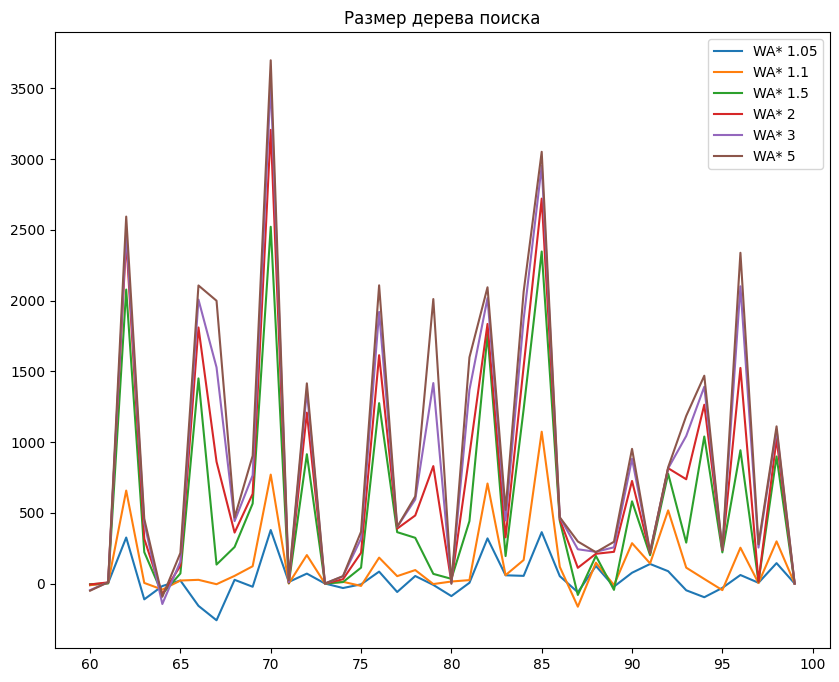

In [148]:
fig = plt.figure(num='Multiple Plots', figsize=(10, 8))

ax2 = fig.add_subplot(1, 1, 1) 
ax2.set_title('Размер дерева поиска')
ax2.plot(range(60,100), np.array(resA['st_size'])[60:100] - np.array(resWA1_05['st_size'])[60:100], label='WA* 1.05')
ax2.plot(range(60,100), np.array(resA['st_size'])[60:100] - np.array(resWA1_1['st_size'])[60:100], label='WA* 1.1')
ax2.plot(range(60,100), np.array(resA['st_size'])[60:100] - np.array(resWA1_5['st_size'])[60:100], label='WA* 1.5')
ax2.plot(range(60,100), np.array(resA['st_size'])[60:100] - np.array(resWA2['st_size'])[60:100], label='WA* 2')
ax2.plot(range(60,100), np.array(resA['st_size'])[60:100] - np.array(resWA3['st_size'])[60:100], label='WA* 3')
ax2.plot(range(60,100), np.array(resA['st_size'])[60:100] - np.array(resWA5['st_size'])[60:100], label='WA* 5')
# ax2.plot(range(len(resA['st_size'])), resA['st_size'], label='A*')
ax2.legend()

plt.show()

### Вывод по карте

Для данной карты наблюдается обратная ситуция, по сравнению с предыдущими двумя. Здесь чем сильнее мы полагаемся на расстояния напрямую до цели, тем выгоднее трейд-офф между скоростью и качеством. Получается, что в этот раз алгоритм WA* уже может быть использован в качестве альтернативы A*. А обясняется тем же, чем можно объяснить непременимость WA* в предыдущих случаях - типом карты. Данная карта - это городская карта, то есть специально спроектированная для того, чтобы минимизировать путь между любыми двумя точками. Минимальный путь - это прямая между этими точками, поэтому чем больше мы полагаемся на путь напрямик, тем эффективнее наша стратегия, так как данная карта специально была под это разработана.

# Итоговый вывод:

На вопрос насколько сильны мы теряем в качестве и получаем в скорости при использовании WA* однозначно ответить не получится.
Но можно сказать на каких картах этот трейд-офф (скорость/качество) говорит в пользу WA*. Это те карты карты, которые специально спроектированы под минимизацию пути из любых двух точек (как например город). 
А игровые карты (как наши первые два примера) можно сказать одни из худших вариантов для использования WA*, так как специально спроектированы так, чтобы игрок ходил по ним как можно дольши. Поэтому при попытке пройти напрямик алгоритму приходится часто бродить по стенкам, что увеличивает длину пути.